In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Derivative of a simple function with one input
$y=3x^2-4x+5$

In [2]:
def f(x):
    return 3*x**2 - 4*x + 5

In [3]:
f(3.0)

20.0

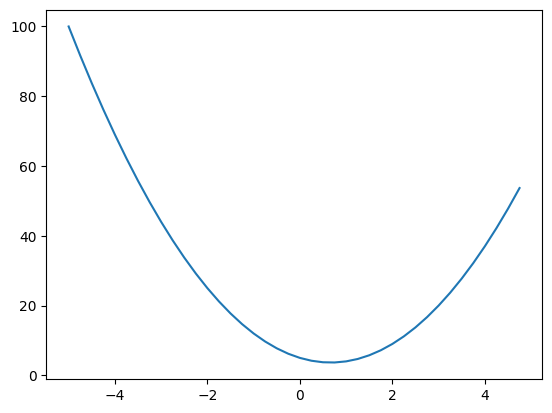

In [4]:
xs = np.arange(-5.0, 5.0, 0.25)
ys = f(xs)
plt.plot(xs, ys)

Then what about the derivative of this y. We do not do what we did in calcus class to write out all terms on paper. We just need to know what it means by its definitation.
> If we slightly bump up by small number `h`, how does the function respond. The slope response goes up or goes down and by how much.
https://en.wikipedia.org/wiki/Derivative
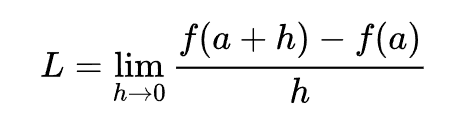

In [5]:
h = 0.00001
a = 3.0 # x = -3.0 going down, x = 2/3 almost stay the same
how_function_respond = f(a + h) - f(a) # The function will go up or go down
normalized_respond_slope = how_function_respond / h
normalized_respond_slope

14.00003000000538

## Derivative of a function with multiple inputs

In [6]:
# Inputs
a = 2.0
b = -3.0
c = 10.0

h = 0.00001
d1 = a*b + c
# Bump up a. Also try b and c
a += h
d2 = a*b + c

# a is slight more positive but b is a negative number
(d2 - d1) / h

-3.000000000064062

## Starting core `Value` object

In [50]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0
        self.label = label
        
        self._backward = lambda: None # For leaf node, it should be none
        self._prev = set(_children) # Used for keep a expr graph to know what values produce current value
        self._op = _op # Operation happens
        
        
    def __repr__(self):
        # Wraper is to provide us a way to print a nice-looking expr
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other) # to deal with a * 2
        # It should not be self.data + other, cause other is an obj
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    
    def __radd__(self, other):
        return self + other
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def tanh(self):
        # Implement tanh function as a modlue rather than atomic operations
        # as long as we know how to differentiate it.
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')
        
        def _backward():
            self.grad = (1 - t ** 2) * out.grad # Because of the chain rule, should always times out.grad
        out._backward = _backward
        return out
    
    def backward(self):
        topo_order = []
        visited = set()
        def build_topo(node):
            if node not in visited:
                visited.add(node)
                for v in node._prev:
                    build_topo(v)
                topo_order.append(node)
        build_topo(self)

        self.grad = 1
        for node in reversed(topo_order):
            node._backward()
    
    # More Operations
    def __rmul__(self, other):
        '''
        To deal with 2 * a where 2.__mul__() is not defined to times Value obj
        '''
        return self * other
    
    def exp(self):
        out = Value(math.exp(self.data), (self, ), 'exp')
        def _backward():
            self.grad += out.grad * math.exp(self.data)
        out._backward = _backward
        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only support int/float powers for now"
        out = Value(self.data**other, (self, ), f"**{other}")
        def _backward():
            self.grad += out.grad * other * (self.data ** (other - 1))
        out._backward = _backward
        return out
    
    def __truediv__(self, other):
        return self * other**-1
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)

a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
d = a*b; d.label = 'd'
e = d + c; e.label = 'e'
f = Value(-2.0, label='f')
L = e * f; L.label = 'L'
L

Value(data=-8.0)

In [8]:
L._prev, L._op

({Value(data=-2.0), Value(data=4.0)}, '*')

In [9]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(node):
        if node not in nodes:
            nodes.add(node)
        for child in node._prev:
            edges.add((child, node))
            build(child)
    build(root)
    return nodes, edges

def draw(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
    nodes, edges = trace(root)
    for node in nodes:
        uid = str(id(node))
        dot.node(name=uid, label="%s | data %.4f | grad %.4f" % (node.label, node.data, node.grad), shape='record')
        if node._op:
            dot.node(name=uid + node._op, label=node._op)
            dot.edge(uid + node._op, uid)
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    return dot

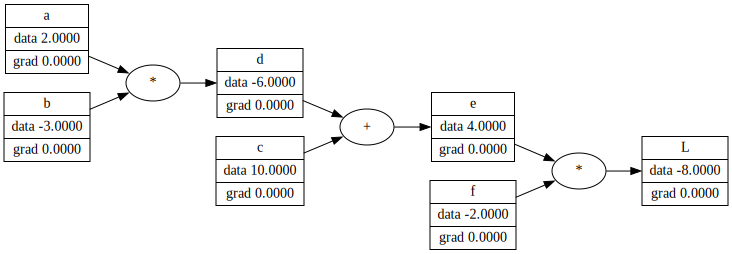

In [10]:
draw(L)

Run backprop. Reverse from `L` to calculate gradients along all intermediate values. The derivatives respect to `L` of every node will be calculated. Some of these `a`, `b`, `c` and `f` will eventually represent weights in nerual networks, we are very interested in how these weights impacting the loss function which is basically the derivative. Others will be data which are fixed and weights are iterative.

Initially, we assume every node has no effect on the output. Thus the gradient of each node is set to `0`.

## Back Propgation
### Example 1

In [11]:
# Mannual calculcation of gradients
def lol():
    # Inline gradient check for all intermediate node.
    h = 0.000001
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    d = a*b; d.label = 'd'
    e = d + c; e.label = 'e';
    f = Value(-2.0, label='f')
    L = e * f; L.label = 'L'
    L1 = L.data
    
    a = Value(2.0, label='a')
    b = Value(-3.0+h, label='b')
    c = Value(10.0, label='c')
    d = a*b; d.label = 'd'
    e = d + c; e.label = 'e';
    f = Value(-2.0, label='f')
    L = e * f; L.label = 'L'
    L2 = L.data
    
    print((L2 - L1) / h)
lol()

-4.000000000559112


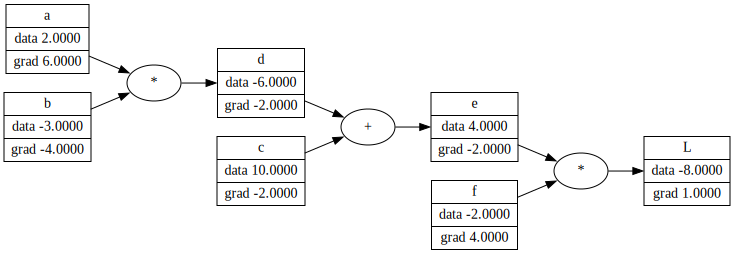

In [12]:
L.grad = 1

# Then look at the derivatives of L wrt. e and f
# L = e * f. dL / de = f, symmetrically dL / df = e
e.grad = -2.0
f.grad = 4.0

# If you know how c impacts e and how e impacts L
# You can somehow put impacts together and know how c impacts L
# Chain Rule:
# dL / dc = (dL / de) * (de / dc)
# Local derivative: e = d + c -> de / dc = 1
# dL / dc = e.grad * 1 = -2.0
c.grad = e.grad * 1
d.grad = e.grad * 1

# dL / da = (dL / de) * (de / dd) * (dd / da)
# d = a * b -> dd / da = b
# KNOWN: (dL / de) * (de / dd) = dL / dd = -2.0
# dL / da = -2.0 * -3.0 = 6.0
a.grad = 6.0
b.grad = -4.0

draw(L)

One step optimization

In [13]:
   # Nudge all inputs(leaf nodes) to increase L to make it close to 0
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

d = a * b
e = d + c
L = e * f
print(L.data)

-7.286496


### Example 2: Neuron

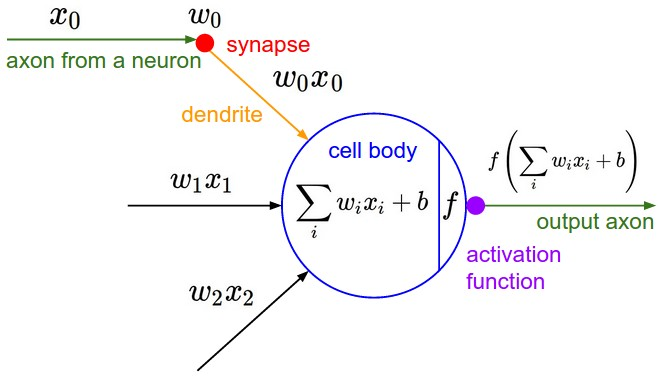

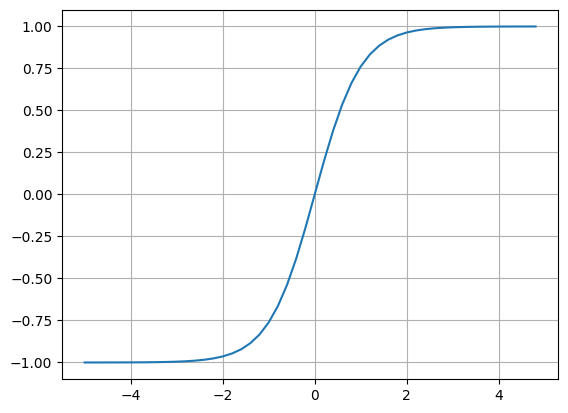

In [14]:
# Activation function: Tanh
# inputs get squashed on y coordinate. 
# The function will only go up to one and plateau out. 
# So if you pass in very positive input, we will cap it smoothly at one.
plt.plot(np.arange(-5, 5, 0.2), np.tanh(np.arange(-5, 5, 0.2))); plt.grid()

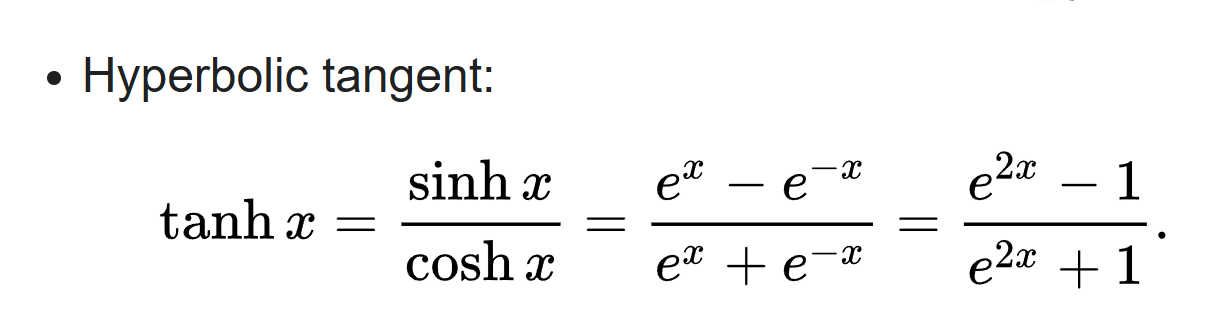

In [15]:
# Inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# Weights(Synapse)
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# Bias
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1+x2w2'
n = x1w1x2w2 + b; n.label = 'n'

# We only implemented plus and times so far. So we cant implement tanh using plus and times.
# If we use np.tanh, it can not be involved in graph.
# o = Value(np.tanh(n.data), label = 'o')

o = n.tanh(); 
o.label = 'output'
o.backward()

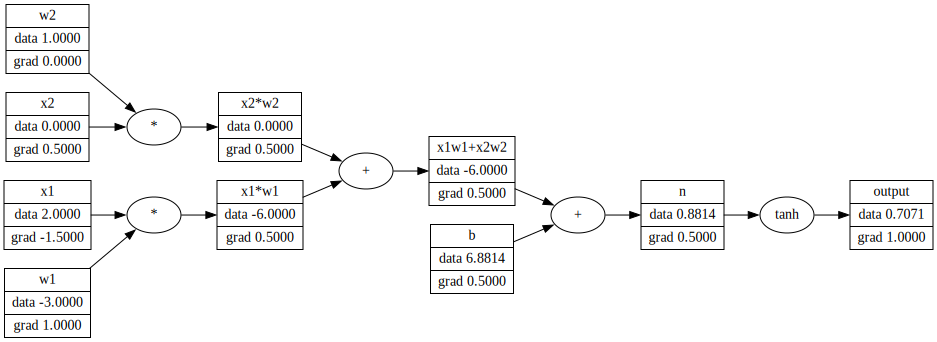

In [16]:
draw(o)

In [17]:
o.grad = 1

In [18]:
# Wikipidea told us. dtanh(x)/dx = 1-tanh^2(x)
# do / dn = dtanh(n) / dn = 1-tanh^2(n)
n.grad = 1 - o.data**2

# Plus is just the distributor of gradients, then
# previous gradient will flow to its children
b.grad = n.grad; x1w1x2w2.grad = n.grad
x1w1.grad = x1w1x2w2.grad; x2w2.grad = x1w1x2w2.grad

x2.grad = x2w2.grad * w2.data
w2.grad = x2w2.grad * x2.data
x1.grad = x1w1.grad * w1.data
w1.grad = x1w1.grad * x1.data

## Implement Backward()
We layout mathematical expression and go backwards through the expression

In [19]:
o.grad = 1
o._backward()
n._backward()
x1w1x2w2._backward()
x2w2._backward()
x1w1._backward()

We can further use topological sort to implement a backward funciton for a whole expre graph.
> From Wiki: A topological sort is a graph traversal in which each node v is visited only after all its dependencies are visited.

In [20]:
topo_order = []
visited = set()
def build_topo(node):
    if node not in visited:
        visited.add(node)
        for v in node._prev:
            build_topo(v)
        topo_order.append(node)
build_topo(o)
print(topo_order)

o.grad = 1
for node in reversed(topo_order):
    node._backward()
    
# Move it to Value obj

[Value(data=1.0), Value(data=0.0), Value(data=0.0), Value(data=2.0), Value(data=-3.0), Value(data=-6.0), Value(data=-6.0), Value(data=6.881373587019543), Value(data=0.8813735870195432), Value(data=0.7071067811865476)]


In [21]:
o.backward()

### Fix a bug
When we use a node multiple times, the gradient will be overwritten rather than upadating correctly. Thus we need to change the `gradient update` function in `Value`. According to multivariable case of the chain rule on wiki, we need to `+=`.

### Breaking up `tanh` with more operations
It's up to you to implement what operations you like. You can certainly implement atomic operations to compsite `tanh` or simply implement the entire module as one function.

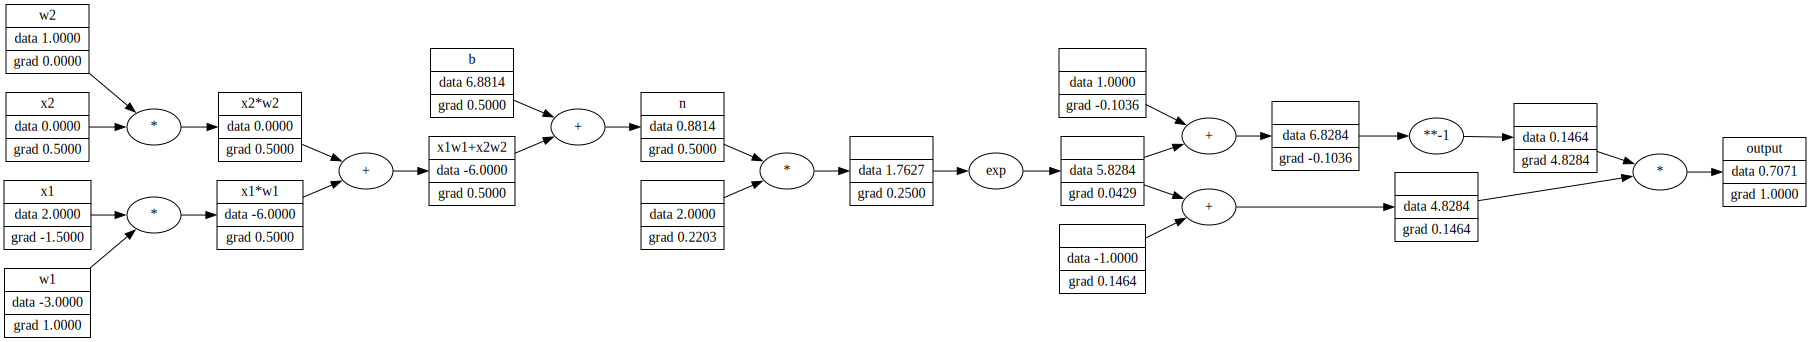

In [22]:
# Inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# Weights(Synapse)
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# Bias
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1+x2w2'
n = x1w1x2w2 + b; n.label = 'n'
# ----
e = (2*n).exp()
o = (e - 1) / (e + 1)
# ----
o.label = 'output'
o.backward()
draw(o)

## Same thing with PyTorch
Tensors are just n-dimensional arrays of scalars.

In [28]:
import torch

x1 = torch.Tensor([2.0]).double()                  ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                  ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()                 ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                  ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()    ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print("-----------")
print('x2', x2.grad)
print('w2', w2.grad)
print('x1', x1.grad)
print('x1', w1.grad)

0.7071066904050358
-----------
x2 tensor([0.5000], dtype=torch.float64)
w2 tensor([0.], dtype=torch.float64)
x1 tensor([-1.5000], dtype=torch.float64)
x1 tensor([1.0000], dtype=torch.float64)


## Build out a NN in micrograd
Multi-layer perception

In [86]:
import random

class Neuron:
    def __init__(self, n_input):
        self.w = [Value(random.uniform(-1.0, 1.0)) for _ in range(n_input)]
        self.b = Value(random.uniform(-1.0, 1.0))
        
    def __call__(self, x):
        # n = Neuron(2)
        # n of x: n(x) -> call
        # w * x + b
#         act = sum(wi*xi for wi, xi in zip(self.w, x)) + self.b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]

    
class Layer:
    def __init__(self, n_input, n_out):
        self.neurons = [Neuron(n_input) for _ in range(n_out)]
    
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
#         params = []
#         for neuron in self.neurons:
#             params.extend(neuron.partameters())
#         return params
    
class MLP:
    def __init__(self, n_input, n_outs):
        size = [n_input] + n_outs
        self.layers = [Layer(size[i], size[i+1]) for i in range(len(n_outs))]
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [90]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x), len(n.parameters())

(Value(data=-0.8728585427497835), 41)

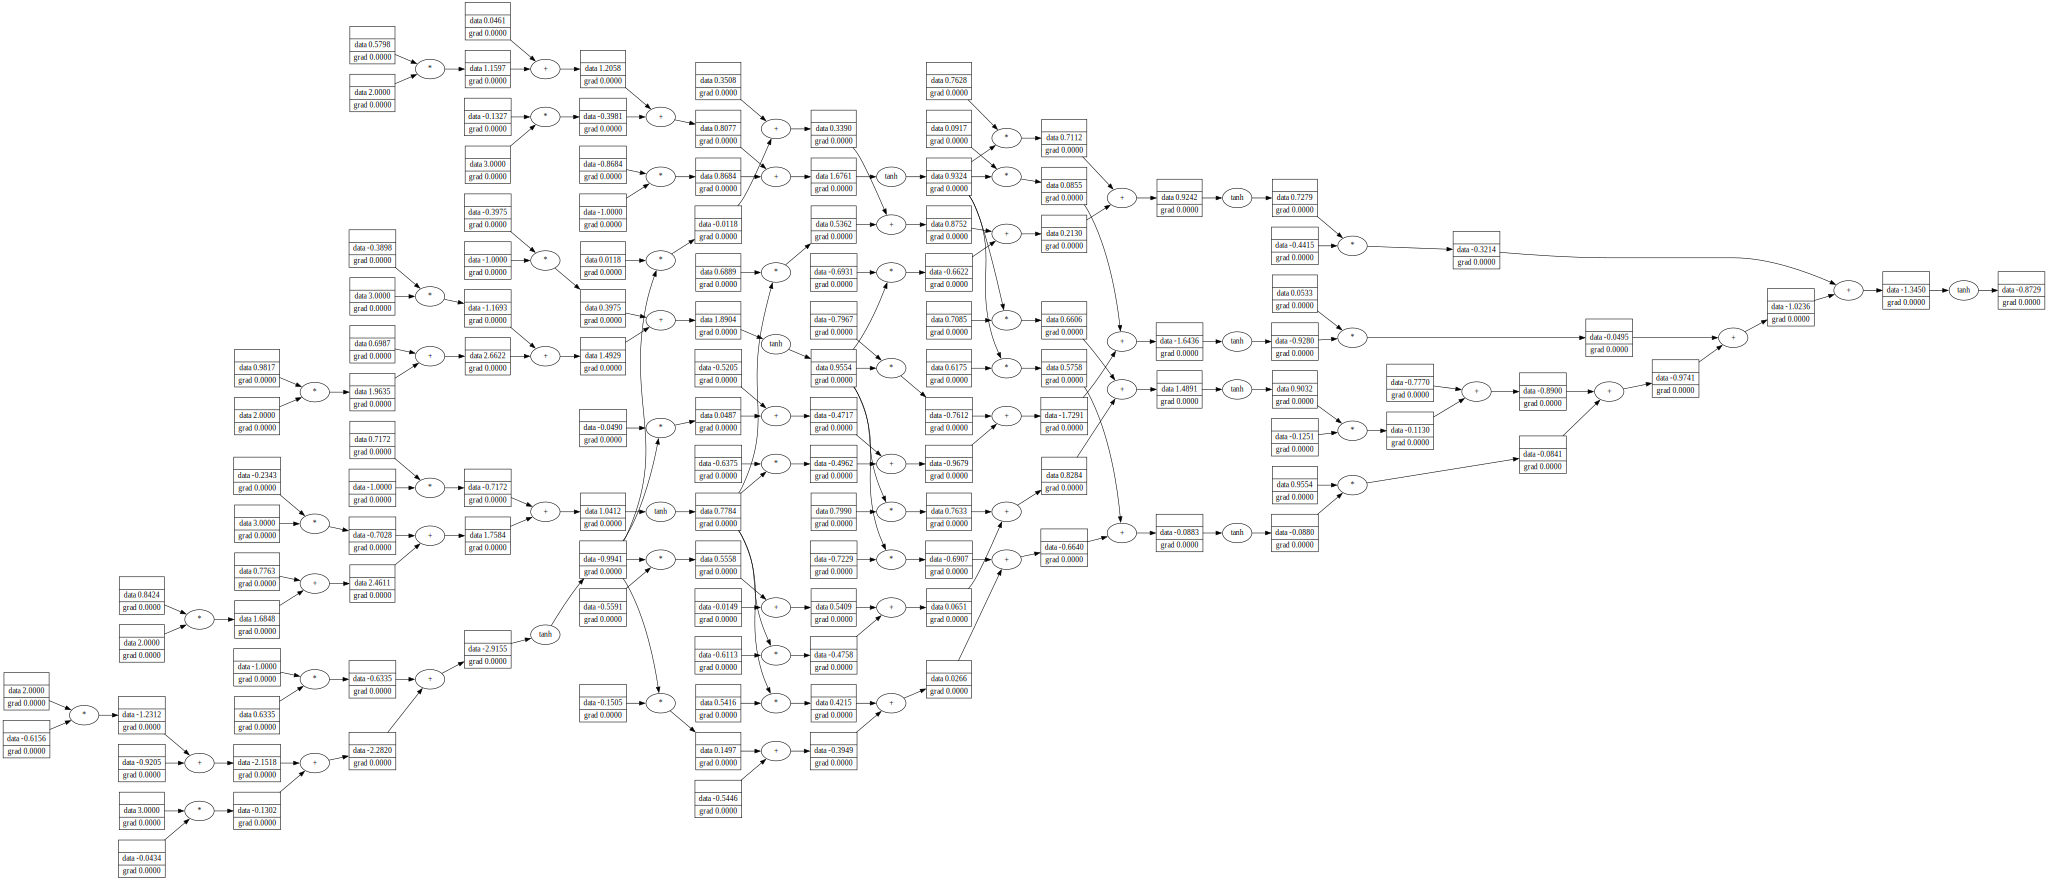

In [91]:
draw(n(x))

## A tiny dataset and loss function

In [175]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]
ys = [1.0, -1.0, -1.0, 1.0]

Forward pass

In [168]:
ypred = [n(x) for x in xs]
loss = sum([(yout - ygt)**2 for yout, ygt in zip(ypred, ys)])
loss

Value(data=2.6959058903102387e-05)

Backward pass

In [169]:
loss.backward()

In [97]:
# weight: w and bias: b can be changed to make the loss smaller while input data: xs are fixed.
n.layers[0].neurons[0].w[0].grad, n.layers[0].neurons[0].w[0].data

(0.0057832518282405435, -0.6156170581386358)

how to find all parameters we want to change. Then we will nudge everyone of them a tiny amount based on the gradient information.

Update

In [170]:
for p in n.parameters():
    p.data += -0.01 * p.grad

In [155]:
# weight: w and bias: b can be changed to make the loss smaller while input data: xs are fixed.
n.layers[0].neurons[0].w[0].grad, n.layers[0].neurons[0].w[0].data

(0.026259318299822917, -0.5810222400474032)

Recalculate the loss after the optimization

In [171]:
ypred = [n(x) for x in xs]
loss = sum([(yout - ygt)**2 for yout, ygt in zip(ypred, ys)])
loss

Value(data=8.955555634288003e-07)

In [172]:
ypred

[Value(data=0.9999740431997631),
 Value(data=-0.9990543880497283),
 Value(data=-0.9999930540027303),
 Value(data=0.9999744735318613)]

### Training the network, full loop

In [200]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]
ys = [1.0, -1.0, -1.0, 1.0]
n = MLP(3, [4, 4, 1])

In [201]:
steps = 100
for step in range(steps):
    # Forward
    ypred = [n(x) for x in xs]
    loss = sum([(yout - ygt)**2 for yout, ygt in zip(ypred, ys)])

    # Important here!!!!! Or it will be accumulated together
    # Result is converging super quickly as unexpected.
    for p in n.parameters():
        p.grad = 0
    # Backward
    loss.backward()
    
    # Update
    for p in n.parameters():
        p.data += -0.01 * p.grad
    
    if step % 10 == 0:
        print(step, loss.data)
print(f"Final pred after {steps} steps: {[y.data for y in ypred]}")

0 7.235726815915614
10 5.068853878889609
20 3.4566235417583835
30 1.998163510670297
40 0.9645177987969088
50 0.5127454569711032
60 0.3226658458442419
70 0.22834150335334125
80 0.17424336451475897
90 0.13983350359610522
Final pred after 100 steps: [0.8717730603975961, -0.868252212553112, -0.7910204852870957, 0.7979919747359312]


# You may have lots of bugs in the code and your network may acutally work